# Climate Change Impact on Photovoltaic Energy Production In the Italian Landscape

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import os
import zipfile
import shutil


## Download Climate Data
**Please Note:** This work had considered the relative humidity, a parameter that is currently not available in the datasets, but was available at the time of coding this project. 

To run this notebook, any reference to *hurs* (relative humidity) must be neglected.


To avoid downloading the whole dataset used for the project, for testing purposes consider downloading only data for [2026-2030] and [2031-2035], for example. 

In [ ]:
import cdsapi # Must be installed and requires registration in order to obtain the API key, as in https://cds-beta.climate.copernicus.eu/how-to-api

c = cdsapi.Client()

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'experiment': 'rcp_2_6',
        'rcm_model': 'gerics_remo2015',
        'gcm_model': 'mohc_hadgem2_es',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2026', '2031', '2036',
            '2041', '2046', '2051',
            '2056', '2061', '2066',
            '2071', '2076',
        ],
        'end_year': [
            '2030', '2035', '2040',
            '2045', '2050', '2055',
            '2060', '2065', '2070',
            '2075', '2080',
        ],
        'domain': 'europe',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': [
            '10m_wind_speed', '2m_air_temperature', '2m_surface_specific_humidity',
            'mean_precipitation_flux', 'surface_solar_radiation_downwards',
        ],
    },
    'download.zip')

Extracting downloaded files and ordering them in the required folder structure to run the notebook

In [11]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def extract_and_organize():
    zip_file = 'download.zip'
    extraction_dir = 'temp_extraction'
    
    # Extract all files to a temporary directory
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    
    # Define scenarios and variables
    scenarios = ['rcp26', 'rcp85']
    variables = ['tas', 'rsds', 'sfcWind', 'huss', 'hurs', 'pr']
    
    # Organize files
    for filename in os.listdir(extraction_dir):
        if filename.endswith('.nc'):
            # Parse filename to get scenario and variable
            parts = filename.split('_')
            var = parts[0] # According to the naming convention of this dataset
            scenario = parts[3] # According to the naming convention of this dataset
            
            # Ensure the variable and scenario are in our lists
            if var in variables and any(s in scenario for s in scenarios):
                # Determine the correct scenario folder name
                scenario_folder = 'rcp26' if 'rcp26' in scenario else 'rcp85'
                
                # Create the target directory
                target_dir = os.path.join('RCM', scenario_folder, var)
                ensure_dir(target_dir)
                
                # Move the file to the target directory
                source_path = os.path.join(extraction_dir, filename)
                target_path = os.path.join(target_dir, filename)
                shutil.move(source_path, target_path)
    
    # Remove the temporary extraction directory
    shutil.rmtree(extraction_dir)

# Run the extraction and organization process
extract_and_organize()

print("Extraction and organization complete.")

Extraction and organization complete.


## Loading Climate Data

In [ ]:
rcps = ['rcp85', 'rcp26']
vars = ['tas', 'rsds', 'sfcWind', 'huss', 'hurs', 'pr' ]
years = np.arange(2025, 2080, 5)

datasets_loaded = {}
for rcp in rcps:
    for var in vars:
        url = 'RCM/'+rcp+'/'+var+'/'
        print(url)
        for year in years:
            filename = var+'_EUR-22_MOHC-HadGEM2-ES_'+rcp+'_r1i1p1_GERICS-REMO2015_v1_day_'+str(year-4)+'0101-'+str(year)+'1230.nc'
            
            file = url+filename
            print(file)
            #Load data
            ds = xr.open_dataset(file)
            
            datasets_loaded[(rcp,var,year)] = ds

Let's see how this data is stored. We see that it has Coordinates with a Rotated Grid (Data variable: rotated_latitude_longitude) in which the North Pole of the grid has been moved in order to have a more homogenous grid over Europe and have smoother boudary conditions:
* grid_north_pole_latitude = 39.25
* grid_north_pole_longitude = -162

Then we have the main variable ('tas': Temperature At the Surface) defined over the rotated grid. 

We will need to pass from one grid to the other in order to visualize data correctly

In [34]:
ds = datasets_loaded[('rcp26','rsds',2025)]
ds

<xarray.Dataset>
Dimensions:                     (time: 1800, bnds: 2, rlat: 201, rlon: 225, vertices: 4)
Coordinates:
  * time                        (time) object 2021-01-01 12:00:00 ... 2025-12...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object ...
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    rsds                        (time, rlat, rlon) float32 ...
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp26
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/efb51752-24a1-48f5-b77c-3f4f...

To plot the data correctly, we need to use the Cartopy library to introduce the correct projection of the spacial coordinates.

In [35]:
#Defining the Projection used in this Dataset

import cartopy.crs as ccrs
rotated_pole = ccrs.RotatedPole(
    pole_latitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_latitude"]
   ,pole_longitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_longitude"]
)

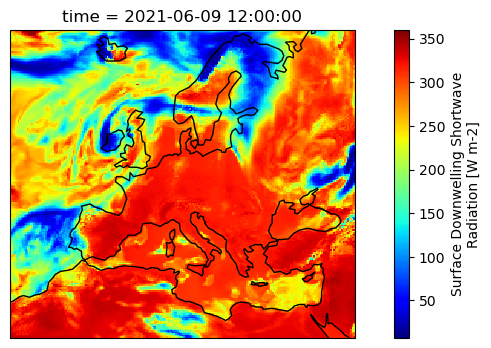

In [36]:
#Check that the Porjection correctly places the data in the European region

plt.figure(figsize=(10, 4))
ax = plt.axes(projection=rotated_pole) #--> creating an instance of GeoAxes
#ax.set_global()
ds.rsds[158].plot.pcolormesh(
    ax=ax
    ,x="rlon", y="rlat", add_colorbar=True, cmap = 'jet')

ax.coastlines()

If we want to see the data in the Standard Earth Projection (PlateCarree) we can ask to use the PlateCarree projection and transform the data from the old crs to the new one applying a tranformer. We can see how the data acquired in a rectangular area in the Rotated Pole projection is equivalent to this weird shape in the "standard" projection. 


**Personal note:** the data is in the Rotated Pole. If we provide the means to pass from a coordinate system to the other (transform) we can see the data in whichever other projection of our choice. 

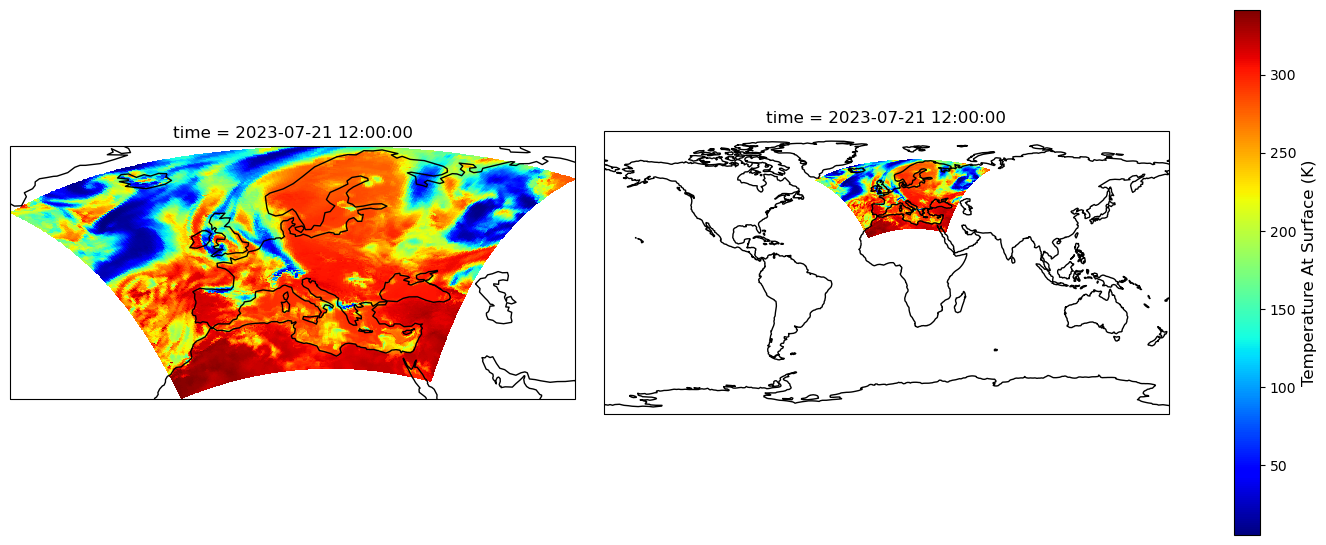

In [37]:
import cartopy.crs as ccrs
#In this case, crs is a Rotated Pole type, thus we select that one
rotated_pole = ccrs.RotatedPole(
    pole_latitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_latitude"]
   ,pole_longitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_longitude"]
)

plate_carree = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': plate_carree})
#Creating an axe with a cartopy crs --> creating an instance of GeoAxes
axs[1].set_global()

img1 = ds.rsds[920].plot.pcolormesh(
    ax=axs[0]
    ,transform=rotated_pole 
    ,x="rlon", y="rlat", add_colorbar=False, cmap = 'jet')

img2 = ds.rsds[920].plot.pcolormesh(
    ax=axs[1]
    ,transform=rotated_pole 
    ,x="rlon", y="rlat", add_colorbar=False, cmap = 'jet')
fig.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.2, wspace=0.05, hspace=0.1)
axs[0].coastlines()
axs[1].coastlines()

cbar = plt.colorbar(img1, ax=axs, orientation='vertical', fraction=.05)
cbar.set_label('Temperature At Surface (K)', size=12) 

plt.show()


## Working on Data

We need to isolate the Italian region. Coordinates for the Italian region in standard Latitude and Longitude are known. We need to convert them into the Rotated grid used as the logical CRS in this Model.
Then we'll create the Italian Dataset and perform some preliminary analysis / data visualization.

In [38]:
#Italina Region Coordinates (taken from lesson on Data)
top = 47
bottom = 36.5
left = 8
right = 18.5


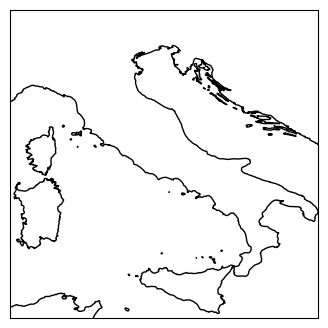

In [39]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure
fig = plt.figure(figsize=(4, 4))

ax = plt.axes(projection=ccrs.PlateCarree())

#Adding coastlines
ax.add_feature(cfeature.COASTLINE)

ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())

# Display the plot
plt.show()




We have now checked that the reference coordinates are correct, we must convert these in Rotated Coordinates, according to the CORDEX data projection

In [40]:
import cartopy.crs as ccrs

rotated_pole = ccrs.RotatedPole(
    pole_latitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_latitude"]
   ,pole_longitude=ds.variables.get("rotated_latitude_longitude").attrs["grid_north_pole_longitude"]
)

base_projection = ccrs.PlateCarree()

vertices = [(left,top),(right,top),(left,bottom), (right,bottom)]
r_vertices = []
for i,v in enumerate(vertices):
    x = v[0]
    y = v[1]
    r_vertices.append(rotated_pole.transform_point(x,y,base_projection))

r_vertices
    




[(-6.812650889707352, -3.2894144287524654),
 (0.3417280893633943, -3.7488453250563256),
 (-8.260319700324603, -13.69162356152812),
 (0.4146837845292324, -14.248598813443854)]

These are the vertices when brought to the Rotated Pole projection. This coordinate transformation does not preserve straight lines and thus this figure is not a polygon. Hence, we need to do a manual selection using the ballparked vertices' coordinates. 

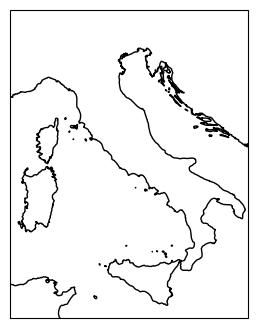

In [41]:
#CAPIRE SE EFFETTIVAMENTE SONO LE COORDINATE GIUSTE.
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#rotated - (left, right, top, bottom)
rl, rr, rb, rt = (-8, 0.5, -14.5, -3.5)

# Create a new figure
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection=rotated_pole)
#Adding coastlines
ax.add_feature(cfeature.COASTLINE)
#Selecting the area to visualize
ax.set_extent([rl, rr, rb, rt], crs=rotated_pole)

# Display the plot
plt.show()


Create a new dictionary dataset with just the data for Italy.

In [ ]:
datasets_it = datasets_loaded
for key, item in datasets_it.items():
    print((key))
    ds_it = item.isel(rlon=(item.rlon >= rl) & (item.rlon <= rr),
                rlat=(item.rlat >= rb) & (item.rlat <= rt))
    datasets_it.update({key: ds_it})



At this point, we have the Italian region; however, we have grid data for areas outside of the Italian state as well (e.g. Croatia) which we are not interested in for this analysis. 

Using a mask found on the Internet for the italian region, we select only the grid-point pertaining the Italian state.

In [ ]:
import geopandas as gpd
import regionmask
#Loading the mask into a variable
italy_shape = gpd.read_file('ItalyShape/ITA_adm0.shp')
#Creating the actual mask
mask = regionmask.mask_geopandas(italy_shape, ds.lon, ds.lat)
#Since by applying the mask the italian points are removed, we need to invert the mask (negative)
mask = np.logical_not(mask)

#Applying the mask
for key, item in datasets_it.items():
    print((key))
    ds_it = item.where(mask)
    datasets_it.update({key: ds_it})

#Let's see if it works
ds_it = datasets_it[('rcp26', 'sfcWind', 2025)].where(mask)
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=rotated_pole)
#ax.set_global()
ds_it.sfcWind[203].plot.pcolormesh(
    ax=ax
    ,x="rlon", y="rlat", add_colorbar=True, cmap = 'jet')

ax.coastlines()

In [ ]:
ds_it.values()

Now let's put all the variables into a single italian dataset in order to facilitate access.


In [ ]:
#Concatenating datasets to obtain the final one
rcps = ['rcp85','rcp26']
rcp_datasets = {}
for rcp in rcps:
    print(rcp)
    var_datasets = {}
    for var in vars:
        selected_datasets = [ds for (rcp_dict, var_dict, year), ds in datasets_it.items() 
                             if rcp_dict == rcp and var_dict == var]
        aux = xr.concat(selected_datasets, dim='time')
        #aux = aux.drop_vars('height')
        var_datasets[var] = aux
    
    print(var_datasets.items())
    
    rcp_datasets[rcp] = xr.combine_by_coords([ds for key, ds in var_datasets.items()], combine_attrs='override', compat='override' )
    
        

Adding the PV_pot information as a another variable to the dataset (see paper)

In [56]:
#Defining parameters
a1 = 1.1035e-3
a2 = -1.4e-7
a3 = -4.715e-6
a4 = 7.64e-6

#def pv_pot(S,T,W, a1, a2, a3, a4):
#    return a1*S + a2*S*S + a3*S*T + a4*S*W
#

def pv_pot(S,T,W):
    c1 = 4.3
    c2 = 0.943
    c3 = 0.028
    c4 = -1.528
    gamma = -0.005
    T_cell = c1 + c2*(T-273.16) + c3*S+ c4*W
    
    return (1+gamma*(T_cell - 25))*(S/1000)
    
for rcp in rcp_datasets.keys():
    S = rcp_datasets[rcp].rsds
    W = rcp_datasets[rcp].sfcWind
    T = rcp_datasets[rcp].tas
    #rcp_datasets[rcp]["pv_pot"] = pv_pot(S,T,W,a1,a2,a3,a4)
    rcp_datasets[rcp]["pv_pot"] = pv_pot(S,T,W)
    



In [ ]:
ds_rcp85.pv_pot

Let's analyze this data: for each variable let's see the time series averaged over months for the next 50 years and the average annual distribution of heat between these days and 50 years.

In [58]:
#Daily dataset
ds_rcp85 = rcp_datasets['rcp85']
ds_rcp26 = rcp_datasets['rcp26']

#Month average spatial dataset
ds_rcp85_yravg = ds_rcp85.resample(time = 'Y').mean()
ds_rcp85_yravg['time'] = ds_rcp85_yravg.time.dt.year

ds_rcp26_yravg = ds_rcp26.resample(time = 'Y').mean()
ds_rcp26_yravg['time'] = ds_rcp26_yravg.time.dt.year

#Month average overall
ds_rcp85_yravg_allita = ds_rcp85_yravg.mean(['rlat', 'rlon'])
ds_rcp26_yravg_allita = ds_rcp26_yravg.mean(['rlat', 'rlon'])

#Year average spatial dataset
ds_rcp85_monavg = ds_rcp85.groupby(ds_rcp85.time.dt.strftime('%Y-%m')).mean('time')
ds_rcp26_monavg = ds_rcp26.groupby(ds_rcp26.time.dt.strftime('%Y-%m')).mean('time')

#Year average overall
ds_rcp85_monavg_allita = ds_rcp85_monavg.mean(['rlat', 'rlon'])
ds_rcp26_monavg_allita = ds_rcp26_monavg.mean(['rlat', 'rlon'])


## Data Analysis

### Climate Evaluation

Let's start by checking what is projected to happen in Italy, climate-wise.

### 1. SW Radiance

Text(0.5, 1.0, '$\\Delta RSDS$ for RCP 8.5')

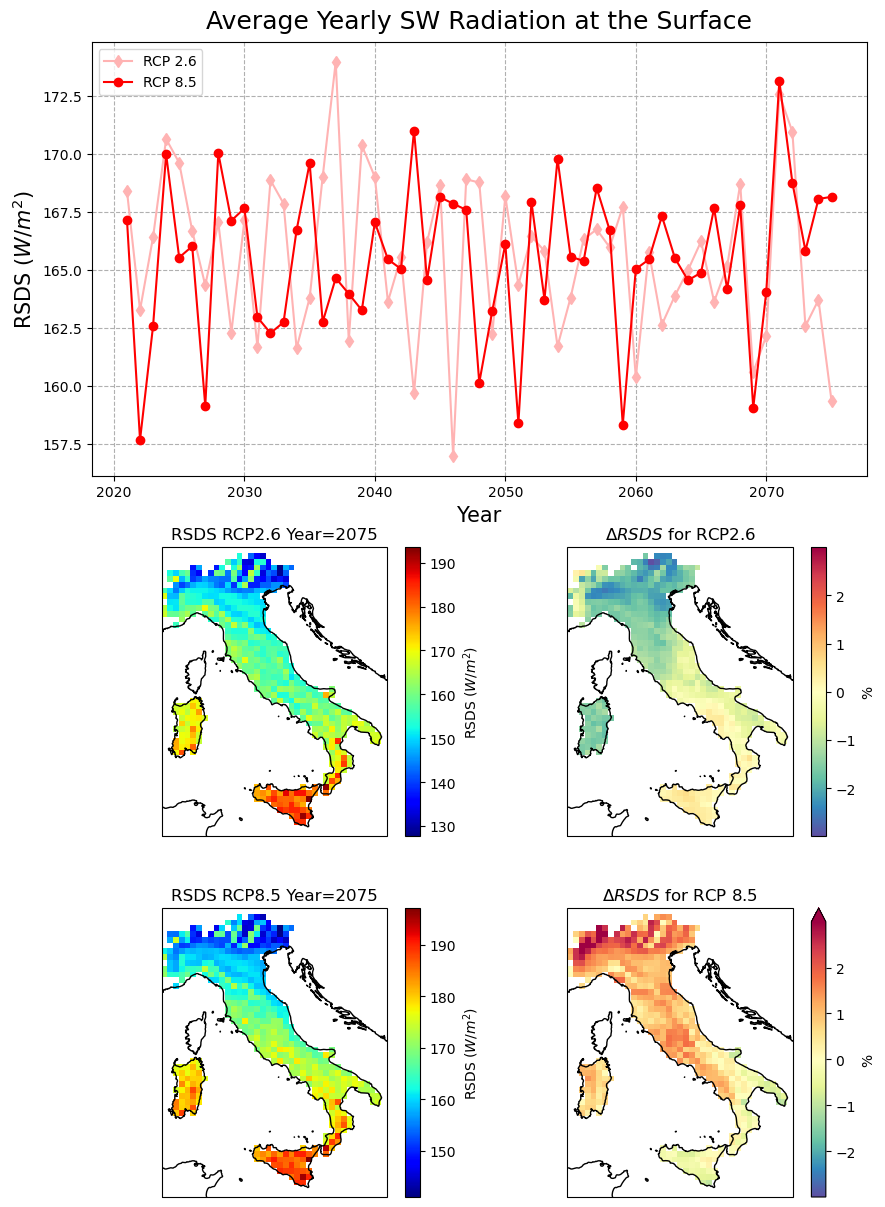

In [59]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

year = 2075
year_ref = 2021
interval = 10

years = ds_rcp26_yravg.time.values
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2, height_ratios=[1.5, 0.1, 1, 0.1, 1], figure = fig, hspace=0.1, wspace=0.1)

ax1 = plt.subplot(gs[0, :],)
ax2 = plt.subplot(gs[2, 0:1], projection=rotated_pole)
ax3 = plt.subplot(gs[2, 1:], projection=rotated_pole)
ax4 = plt.subplot(gs[4, 0:1], projection=rotated_pole)
ax5 = plt.subplot(gs[4, 1:], projection=rotated_pole)

ax1.plot(years, ds_rcp26_yravg_allita.rsds,'d-', c=(1, 0.7, 0.7), label = 'RCP 2.6')
ax1.plot(years, ds_rcp85_yravg_allita.rsds,'o-', c='r', label = 'RCP 8.5')

ref_avg_rcp85 = ds_rcp85_yravg.rsds.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp85 = ds_rcp85_yravg.rsds.sel(time=slice(2066,2075,1)).mean('time')
ref_avg_rcp26 = ds_rcp26_yravg.rsds.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp26 = ds_rcp26_yravg.rsds.sel(time=slice(2066,2075,1)).mean('time')

abs26 = ds_rcp26_yravg.rsds.sel(time=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc26 = (((final_avg_rcp26-ref_avg_rcp26)/ref_avg_rcp26)*100).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)

abs85 = ds_rcp85_yravg.rsds.sel(time=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc85 = (((final_avg_rcp85-ref_avg_rcp85)/ref_avg_rcp85)*100).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)

ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
abs26.colorbar.set_label('RSDS $(W/m^2)$')
abs85.colorbar.set_label('RSDS $(W/m^2)$')
perc26.colorbar.set_label('%')
perc85.colorbar.set_label('%')

#Formatting
ax1.set_title('Average Yearly SW Radiation at the Surface', fontdict={'fontsize': 18}, pad = 10)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('RSDS $(W/m^2)$', fontsize = 15 )
ax1.legend()
ax1.grid(visible=True, ls = '--')

ax2.set_title('RSDS RCP2.6 Year='+str(year))
ax3.set_title('$\Delta RSDS$ for RCP2.6')
ax4.set_title('RSDS RCP8.5 Year='+str(year))
ax5.set_title('$\Delta RSDS$ for RCP 8.5')


**Considerations:**
* Overall similar scenarios, as far as mean values are concerned.
* Latitude Gradient: more SW radiative flux in the Southern Regions.
* Inverted Scenarios: RCP 2.6 has an increase in Southern Regions whereas there is a relative decrease in in the North. The opposite is true for scenario RCP 8.5

### 2. Temperature at Surface

Text(0.5, 1.0, '$\\Delta TAS$ for RCP 8.5')

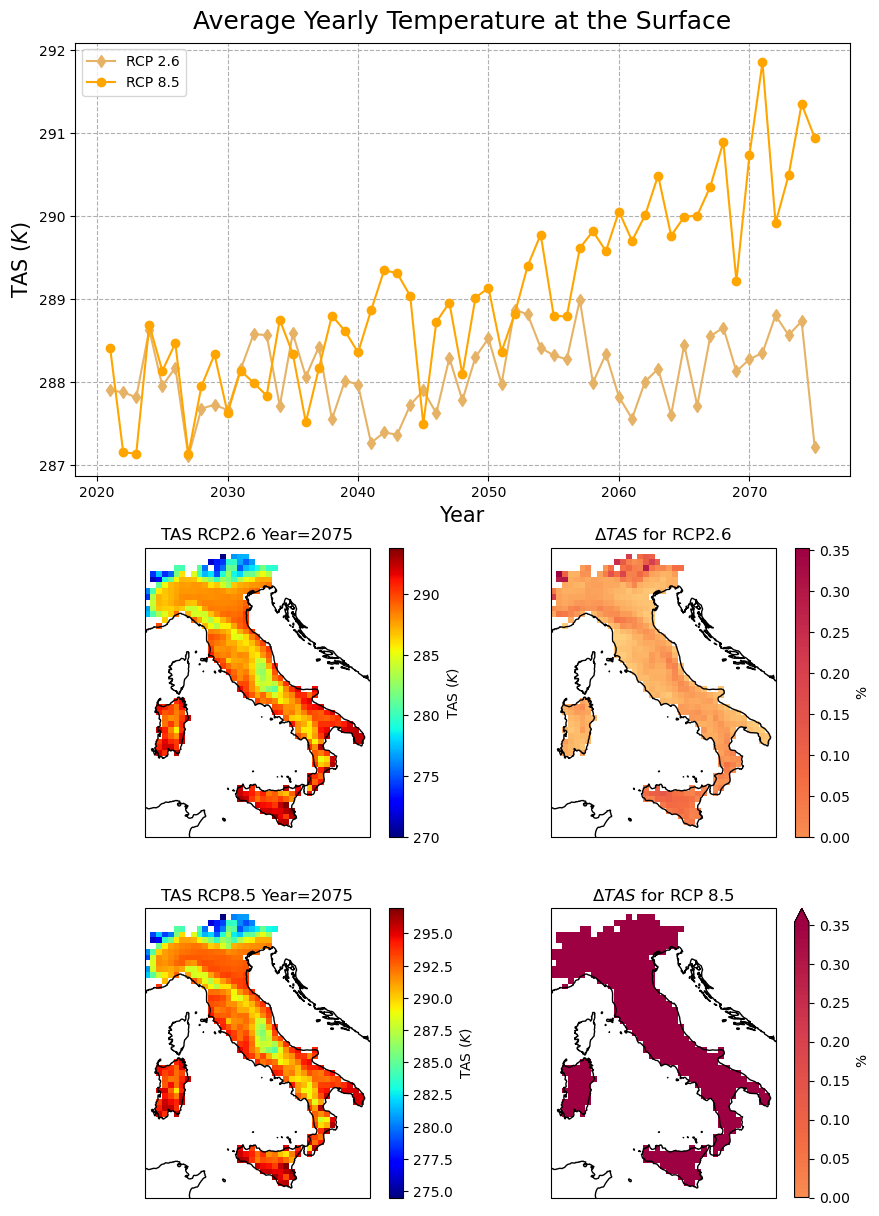

In [60]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

year = 2075
year_ref = 2021
interval = 10

years = ds_rcp26_yravg.time.values
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2, height_ratios=[1.5, 0.1, 1, 0.1, 1], figure = fig, hspace=0.1, wspace=0.1)

ax1 = plt.subplot(gs[0, :],)
ax2 = plt.subplot(gs[2, 0:1], projection=rotated_pole)
ax3 = plt.subplot(gs[2, 1:], projection=rotated_pole)
ax4 = plt.subplot(gs[4, 0:1], projection=rotated_pole)
ax5 = plt.subplot(gs[4, 1:], projection=rotated_pole)

ax1.plot(years, ds_rcp26_yravg_allita.tas,'d-', c=(0.9, 0.7, 0.4), label = 'RCP 2.6')
ax1.plot(years, ds_rcp85_yravg_allita.tas,'o-', c='orange', label = 'RCP 8.5')

ref_avg_rcp85 = ds_rcp85_yravg.tas.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp85 = ds_rcp85_yravg.tas.sel(time=slice(2066,2075,1)).mean('time')
ref_avg_rcp26 = ds_rcp26_yravg.tas.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp26 = ds_rcp26_yravg.tas.sel(time=slice(2066,2075,1)).mean('time')

abs26 = ds_rcp26_yravg.tas.sel(time=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc26 = (((final_avg_rcp26-ref_avg_rcp26)/ref_avg_rcp26)*100).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)

abs85 = ds_rcp85_yravg.tas.sel(time=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc85 = (((final_avg_rcp85-ref_avg_rcp85)/ref_avg_rcp85)*100).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)

ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
abs26.colorbar.set_label('TAS $(K)$')
abs85.colorbar.set_label('TAS $(K)$')
perc26.colorbar.set_label('%')
perc85.colorbar.set_label('%')

#Formatting
ax1.set_title('Average Yearly Temperature at the Surface', fontdict={'fontsize': 18}, pad = 10)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('TAS $(K)$', fontsize = 15 )
ax1.legend()
ax1.grid(visible=True, ls = '--')

ax2.set_title('TAS RCP2.6 Year='+str(year))
ax3.set_title('$\Delta TAS$ for RCP2.6')
ax4.set_title('TAS RCP8.5 Year='+str(year))
ax5.set_title('$\Delta TAS$ for RCP 8.5')


**Considerations:**
* RCP 8.5 brings a drastic increase in Air Temperature of more that 0.35% in the whole Italian region. On average, compared to the RCP 2.6, mean temperature is 2 to 3 K higher

### 3. Wind Speed

Text(0.5, 1.0, '$\\Delta Wind Speed$ for RCP 8.5')

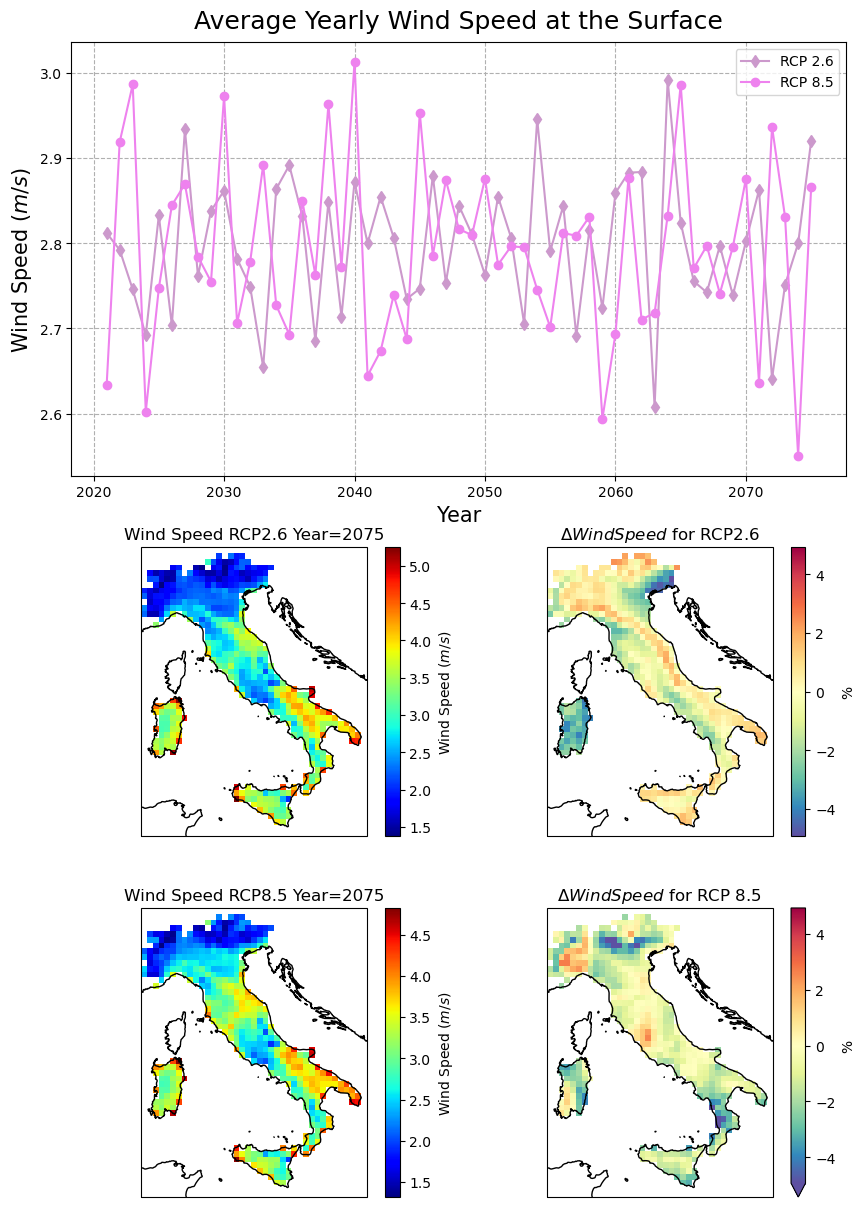

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

year = 2075
year_ref = 2021
interval = 10

years = ds_rcp26_yravg.time.values
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2, height_ratios=[1.5, 0.1, 1, 0.1, 1], figure = fig, hspace=0.1, wspace=0.1)

ax1 = plt.subplot(gs[0, :],)
ax2 = plt.subplot(gs[2, 0:1], projection=rotated_pole)
ax3 = plt.subplot(gs[2, 1:], projection=rotated_pole)
ax4 = plt.subplot(gs[4, 0:1], projection=rotated_pole)
ax5 = plt.subplot(gs[4, 1:], projection=rotated_pole)

ax1.plot(years, ds_rcp26_yravg_allita.sfcWind,'d-', c=(0.8,0.6,0.8), label = 'RCP 2.6')
ax1.plot(years, ds_rcp85_yravg_allita.sfcWind,'o-', c='violet', label = 'RCP 8.5')

ref_avg_rcp85 = ds_rcp85_yravg.sfcWind.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp85 = ds_rcp85_yravg.sfcWind.sel(time=slice(2066,2075,1)).mean('time')
ref_avg_rcp26 = ds_rcp26_yravg.sfcWind.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp26 = ds_rcp26_yravg.sfcWind.sel(time=slice(2066,2075,1)).mean('time')

abs26 = ds_rcp26_yravg.sfcWind.sel(time=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc26 = (((final_avg_rcp26-ref_avg_rcp26)/ref_avg_rcp26)*100).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)

abs85 = ds_rcp85_yravg.sfcWind.sel(time=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc85 = (((final_avg_rcp85-ref_avg_rcp85)/ref_avg_rcp85)*100).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)

ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
abs26.colorbar.set_label('Wind Speed $(m/s)$')
abs85.colorbar.set_label('Wind Speed $(m/s)$')
perc26.colorbar.set_label('%')
perc85.colorbar.set_label('%')

#Formatting
ax1.set_title('Average Yearly Wind Speed at the Surface', fontdict={'fontsize': 18}, pad = 10)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('Wind Speed $(m/s)$', fontsize = 15 )
ax1.legend()
ax1.grid(visible=True, ls = '--')

ax2.set_title('Wind Speed RCP2.6 Year='+str(year))
ax3.set_title('$\Delta Wind Speed$ for RCP2.6')
ax4.set_title('Wind Speed RCP8.5 Year='+str(year))
ax5.set_title('$\Delta Wind Speed$ for RCP 8.5')


**Considerations:** 
* Extreme Events?: Seems like the average wind speed in RCP 8.5 could happen more frequently. Aside from that, this is likely a very uncertain prediction. Overall, winds seem to be less intense but in the North-West region.

### 4. Humidity and Precipitation

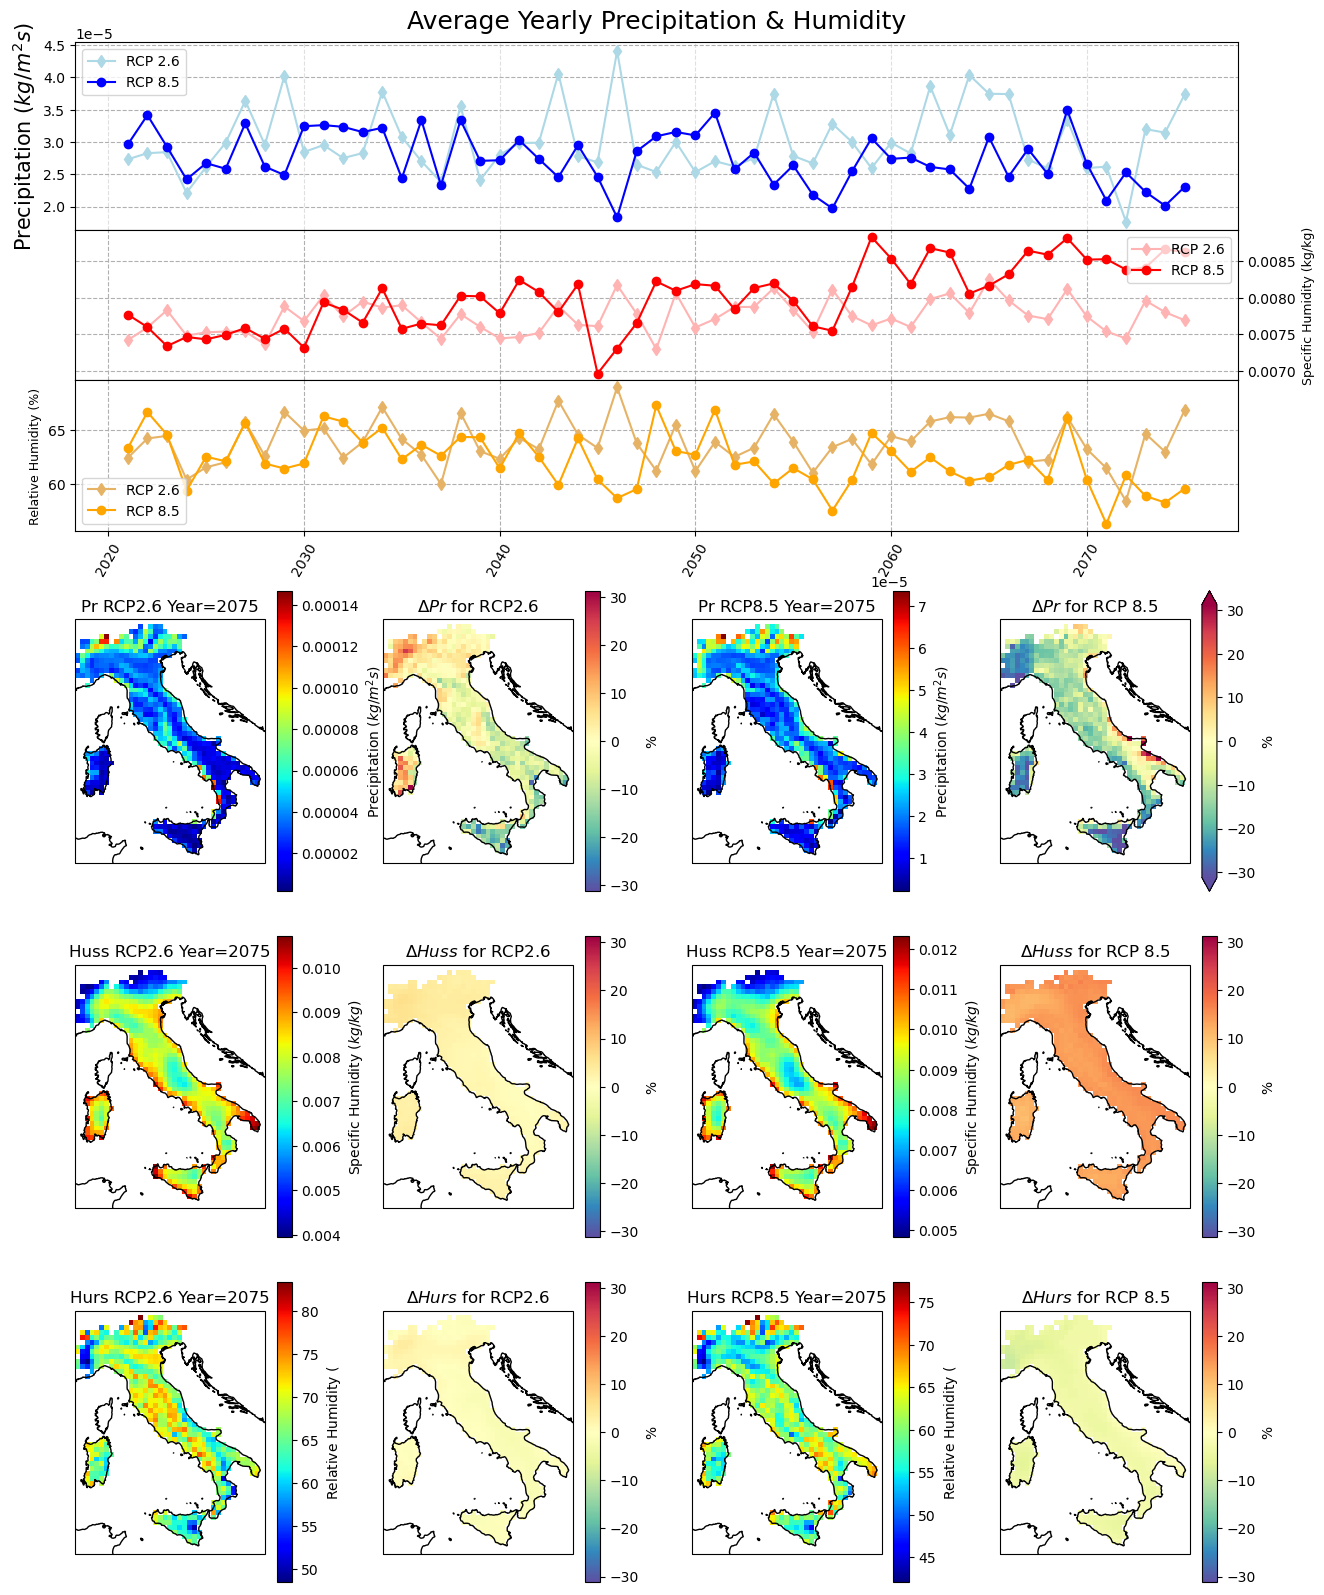

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

year = 2075
year_ref = 2021
interval = 10

years = ds_rcp26_yravg.time.values
fig = plt.figure(figsize=(15, 20))
# Create a gridspec with 2 rows and 2 columns
gs = gridspec.GridSpec(9, 4, height_ratios=[2.5, 2, 2, 0.8,4, 0.6, 4, 0.6, 4], figure = fig, hspace=0, wspace=0.3)

# Creating Subplots
ax1_pr = plt.subplot(gs[0, :],)
ax1_huss = plt.subplot(gs[1, :], sharex = ax1,)
ax1_hurs = plt.subplot(gs[2, :], sharex = ax1)


ax2 = plt.subplot(gs[4, 0], projection=rotated_pole)
ax3 = plt.subplot(gs[4, 1], projection=rotated_pole)
ax4 = plt.subplot(gs[4, 2], projection=rotated_pole)
ax5 = plt.subplot(gs[4, 3], projection=rotated_pole)

ax6 = plt.subplot(gs[6, 0], projection=rotated_pole)
ax7 = plt.subplot(gs[6, 1], projection=rotated_pole)
ax8 = plt.subplot(gs[6, 2], projection=rotated_pole)
ax9 = plt.subplot(gs[6, 3], projection=rotated_pole)

ax10 = plt.subplot(gs[8, 0], projection=rotated_pole)
ax11 = plt.subplot(gs[8, 1], projection=rotated_pole)
ax12 = plt.subplot(gs[8, 2], projection=rotated_pole)
ax13 = plt.subplot(gs[8, 3], projection=rotated_pole)

# Plot the data
ax1_pr.plot(years, ds_rcp26_yravg_allita.pr,'d-', c='lightblue', label = 'RCP 2.6' )
ax1_pr.plot(years, ds_rcp85_yravg_allita.pr,'o-', c='blue', label = 'RCP 8.5' )
ax1_huss.plot(years, ds_rcp26_yravg_allita.huss,'d-', c=(1, 0.7, 0.7), label = 'RCP 2.6')
ax1_huss.plot(years, ds_rcp85_yravg_allita.huss,'o-', c='r', label = 'RCP 8.5')
ax1_hurs.plot(years, ds_rcp26_yravg_allita.hurs,'d-', c=(0.9, 0.7, 0.4),label = 'RCP 2.6')
ax1_hurs.plot(years, ds_rcp85_yravg_allita.hurs,'o-', c='orange',label='RCP 8.5')


pr_ref_avg_rcp85 = ds_rcp85_yravg.pr.sel(time=slice(2021,2030,1)).mean('time')
pr_final_avg_rcp85 = ds_rcp85_yravg.pr.sel(time=slice(2066,2075,1)).mean('time')
pr_ref_avg_rcp26 = ds_rcp26_yravg.pr.sel(time=slice(2021,2030,1)).mean('time')
pr_final_avg_rcp26 = ds_rcp26_yravg.pr.sel(time=slice(2066,2075,1)).mean('time')

huss_ref_avg_rcp85 = ds_rcp85_yravg.huss.sel(time=slice(2021,2030,1)).mean('time')
huss_final_avg_rcp85 = ds_rcp85_yravg.huss.sel(time=slice(2066,2075,1)).mean('time')
huss_ref_avg_rcp26 = ds_rcp26_yravg.huss.sel(time=slice(2021,2030,1)).mean('time')
huss_final_avg_rcp26 = ds_rcp26_yravg.huss.sel(time=slice(2066,2075,1)).mean('time')

hurs_ref_avg_rcp85 = ds_rcp85_yravg.hurs.sel(time=slice(2021,2030,1)).mean('time')
hurs_final_avg_rcp85 = ds_rcp85_yravg.hurs.sel(time=slice(2066,2075,1)).mean('time')
hurs_ref_avg_rcp26 = ds_rcp26_yravg.hurs.sel(time=slice(2021,2030,1)).mean('time')
hurs_final_avg_rcp26 = ds_rcp26_yravg.hurs.sel(time=slice(2066,2075,1)).mean('time')

pr_abs26 = ds_rcp26_yravg.pr.sel(time=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
pr_perc26 = (((pr_final_avg_rcp26-pr_ref_avg_rcp26)/pr_ref_avg_rcp26)*100).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)
pr_abs85 = ds_rcp85_yravg.pr.sel(time=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
pr_perc85 = (((pr_final_avg_rcp85-pr_ref_avg_rcp85)/pr_ref_avg_rcp85)*100).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)

huss_abs26 = ds_rcp26_yravg.huss.sel(time=year).plot.pcolormesh(ax=ax6, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
huss_perc26 = (((huss_final_avg_rcp26-huss_ref_avg_rcp26)/huss_ref_avg_rcp26)*100).plot.pcolormesh(ax=ax7, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)
huss_abs85 = ds_rcp85_yravg.huss.sel(time=year).plot.pcolormesh(ax=ax8, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
huss_perc85 = (((huss_final_avg_rcp85-huss_ref_avg_rcp85)/huss_ref_avg_rcp85)*100).plot.pcolormesh(ax=ax9, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)

hurs_abs26 = ds_rcp26_yravg.hurs.sel(time=year).plot.pcolormesh(ax=ax10, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
hurs_perc26 = (((hurs_final_avg_rcp26-hurs_ref_avg_rcp26)/hurs_ref_avg_rcp26)*100).plot.pcolormesh(ax=ax11, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', norm=norm)
hurs_abs85 = ds_rcp85_yravg.hurs.sel(time=year).plot.pcolormesh(ax=ax12, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
hurs_perc85 = (((hurs_final_avg_rcp85-hurs_ref_avg_rcp85)/hurs_ref_avg_rcp85)*100).plot.pcolormesh(ax=ax13, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', norm=norm)



#Formatting
ax1_pr.set_title('Average Yearly Precipitation & Humidity', fontdict={'fontsize': 18}, pad = 10)
ax1_pr.set_xlabel('Year', fontsize = 15)
ax1_pr.set_ylabel('Precipitation $(kg/m^2s)$', fontsize = 15 )
ax1_pr.legend()
ax1_pr.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, grid_alpha = 0.4)
ax1_pr.grid(visible=True, ls = '--')

ax1_huss.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1_huss.grid(visible=True, ls = '--')
ax1_huss.set_ylabel('Specific Humidity (kg/kg)', fontsize = 9)
ax1_huss.yaxis.set_label_position('right')
ax1_huss.tick_params(axis='y', which='both', labelleft=False, left=False, labelright=True, right = True)
ax1_huss.legend(loc = 'upper right')


ax1_hurs.set_ylabel('Relative Humidity (%)', fontsize = 9)
ax1_hurs.tick_params(axis='x', which='both', labelbottom=False, top=False)
ax1_hurs.grid(visible=True, ls = '--')
ax1_hurs.legend()
ax1_hurs.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, )

ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
ax6.coastlines()
ax7.coastlines()
ax8.coastlines()
ax9.coastlines()
ax10.coastlines()
ax11.coastlines()
ax12.coastlines()
ax13.coastlines()

ax2.set_title('Pr RCP2.6 Year='+str(year))
ax3.set_title('$\Delta Pr$ for RCP2.6')
ax4.set_title('Pr RCP8.5 Year='+str(year))
ax5.set_title('$\Delta Pr$ for RCP 8.5')
ax6.set_title('Huss RCP2.6 Year='+str(year))
ax7.set_title('$\Delta Huss$ for RCP2.6')
ax8.set_title('Huss RCP8.5 Year='+str(year))
ax9.set_title('$\Delta Huss$ for RCP 8.5')
ax10.set_title('Hurs RCP2.6 Year='+str(year))
ax11.set_title('$\Delta Hurs$ for RCP2.6')
ax12.set_title('Hurs RCP8.5 Year='+str(year))
ax13.set_title('$\Delta Hurs$ for RCP 8.5')

pr_abs26.colorbar.set_label('Precipitation $(kg/m^2s)$')
pr_perc26.colorbar.set_label('%')
pr_abs85.colorbar.set_label('Precipitation $(kg/m^2s)$')
pr_perc85.colorbar.set_label('%')
huss_abs26.colorbar.set_label('Specific Humidity $(kg/kg)$')
huss_perc26.colorbar.set_label('%')
huss_abs85.colorbar.set_label('Specific Humidity $(kg/kg)$')
huss_perc85.colorbar.set_label('%')
hurs_abs26.colorbar.set_label('Relative Humidity $(%)$')
hurs_perc26.colorbar.set_label('%')
hurs_abs85.colorbar.set_label('Relative Humidity $(%)$')
hurs_perc85.colorbar.set_label('%')


# Rotate x-axis labels on the first plot
ax1_hurs.tick_params(axis='x', rotation=60)


plt.show()


**Considerations:**
* Lower mean precipitation in RCP 8.5
* Higher specific humidity as expected from the water-vapour feedback
* Slight decrease in Relative Humidity in RCP 8.5, as expected. With higher Temperatures, air can contain more water vapor

Location-wise:
* Precipitation seems to be decreasing by over 30% in Piedmont, Sicily and Sardinia, while having an overall decrease of about 15% in the rest of Italy (RCP8.5). On the contrary, for RCP 2.6 there is an increase of precipitation in Piedmont and Sardinia and still a decrease in Sicily, while remaining pretty stable everywhere else.
* Specific Humidity remains stable in RCP 2.6 and increases abruptly by 15% in RCP 8.5
* Same for relative humidity while in RCP there is between a 5 and 10% decrease all over.

## Solar Power Production

### 1. **Solar Cell Power Potential Production Increase (Yearly)**

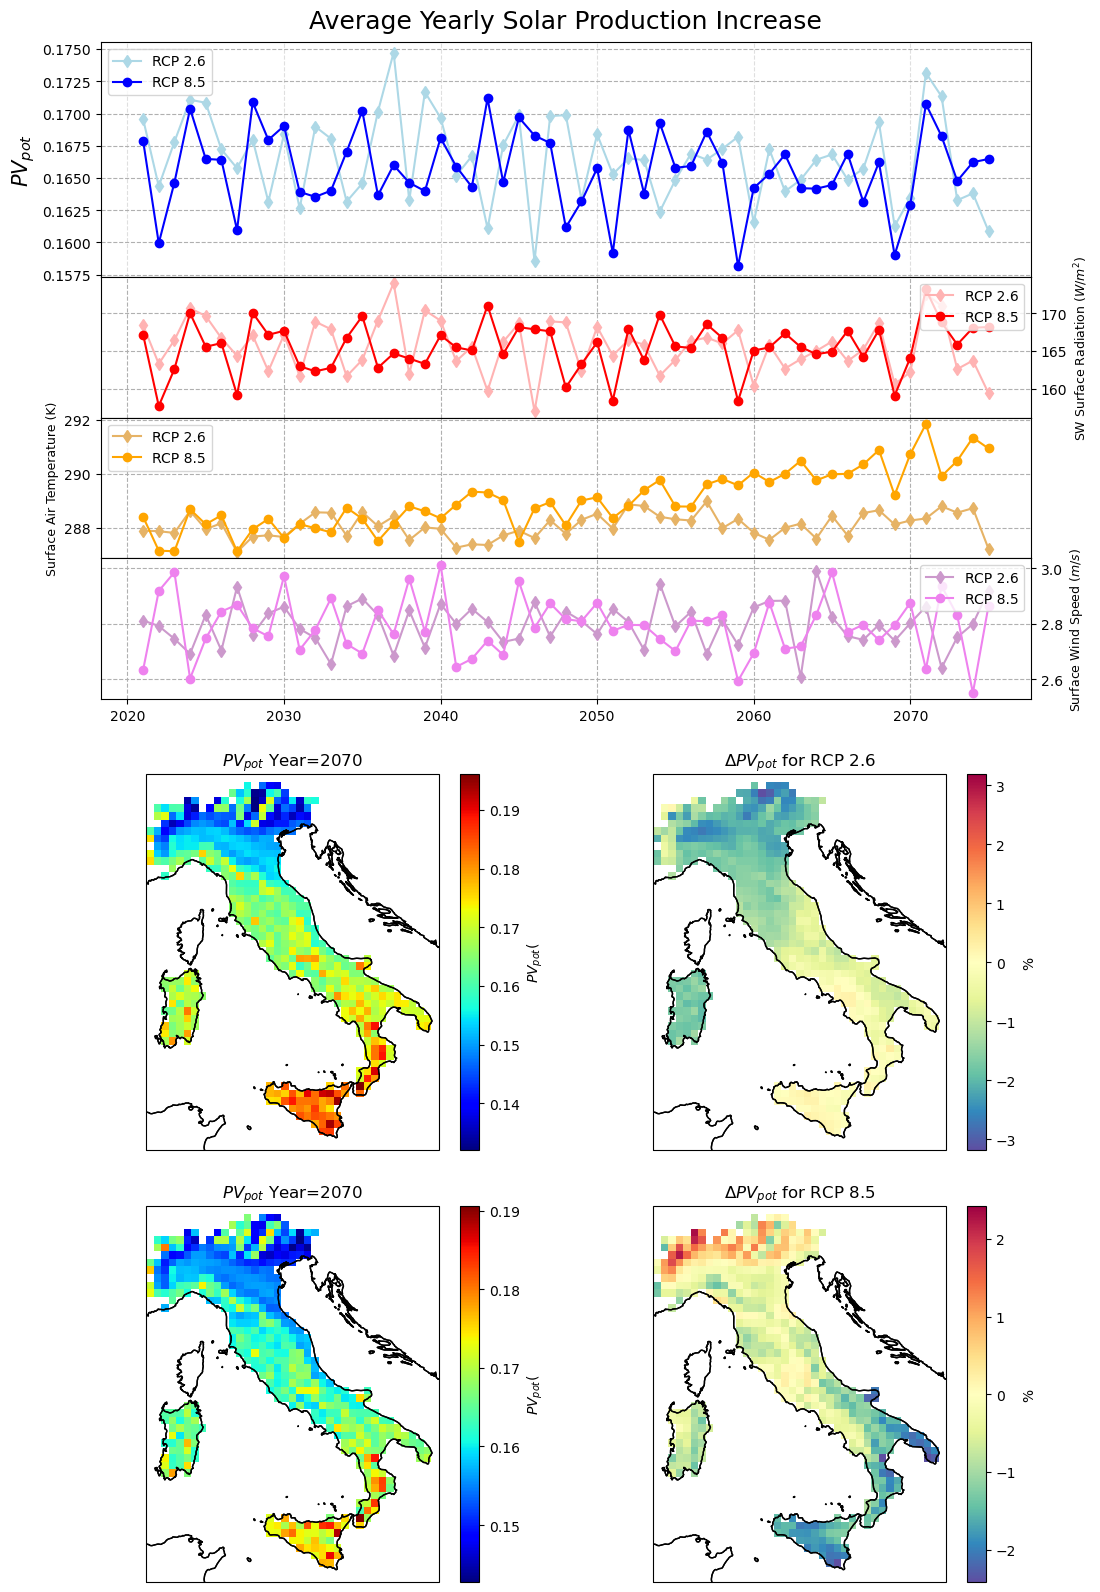

In [65]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

year = 2070
year_ref = 2021

years = ds_rcp26_yravg.time.values
fig = plt.figure(figsize=(12, 20))
# Create a gridspec with 2 rows and 2 columns
gs = gridspec.GridSpec(8, 2, height_ratios=[2.5, 1.5, 1.5, 1.5, 0.8,4, 0.6, 4], figure = fig, hspace=0, wspace=0.2)

# Creating Subplots
ax1 = plt.subplot(gs[0, :],)
ax1_rsd = plt.subplot(gs[1, :], sharex = ax1,)
ax1_tas = plt.subplot(gs[2, :], sharex = ax1)
ax1_wind = plt.subplot(gs[3, :], sharex = ax1)


ax2 = plt.subplot(gs[5, 0:1], projection=rotated_pole)
ax3 = plt.subplot(gs[5, 1:], projection=rotated_pole)

ax4 = plt.subplot(gs[7, 0:1], projection=rotated_pole)
ax5 = plt.subplot(gs[7, 1:], projection=rotated_pole)

# Plot the data
ax1.plot(years, ds_rcp26_yravg_allita.pv_pot,'d-', c='lightblue', label = 'RCP 2.6' )
ax1.plot(years, ds_rcp85_yravg_allita.pv_pot,'o-', c='blue', label = 'RCP 8.5' )
ax1_rsd.plot(years, ds_rcp26_yravg_allita.rsds,'d-', c=(1, 0.7, 0.7), label = 'RCP 2.6')
ax1_rsd.plot(years, ds_rcp85_yravg_allita.rsds,'o-', c='r', label = 'RCP 8.5')
ax1_tas.plot(years, ds_rcp26_yravg_allita.tas,'d-', c=(0.9, 0.7, 0.4),label = 'RCP 2.6')
ax1_tas.plot(years, ds_rcp85_yravg_allita.tas,'o-', c='orange',label='RCP 8.5')
ax1_wind.plot(years, ds_rcp26_yravg_allita.sfcWind,'d-', c=(0.8,0.6,0.8),label = 'RCP 2.6')
ax1_wind.plot(years, ds_rcp85_yravg_allita.sfcWind,'o-', c='violet',label = 'RCP 8.5')


ref_avg_rcp85 = ds_rcp85_yravg.pv_pot.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp85 = ds_rcp85_yravg.pv_pot.sel(time=slice(2066,2075,1)).mean('time')
ref_avg_rcp26 = ds_rcp26_yravg.pv_pot.sel(time=slice(2021,2030,1)).mean('time')
final_avg_rcp26 = ds_rcp26_yravg.pv_pot.sel(time=slice(2066,2075,1)).mean('time')

abs26 = ds_rcp26_yravg.pv_pot.sel(time=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc26 = (((final_avg_rcp26-ref_avg_rcp26)/(ref_avg_rcp26)*100)).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r', label = 'RCP 2.6', )

abs85 = ds_rcp85_yravg.pv_pot.sel(time=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
perc85 = (((final_avg_rcp85-ref_avg_rcp85)/(ref_avg_rcp85))*100).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Spectral_r',  label = 'RCP 8.5', )




#Formatting
ax1.set_title('Average Yearly Solar Production Increase', fontdict={'fontsize': 18}, pad = 10)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('$PV_{pot}$', fontsize = 15 )
ax1.legend()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, grid_alpha = 0.4)
ax1.grid(visible=True, ls = '--')

ax1_rsd.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1_rsd.grid(visible=True, ls = '--')
ax1_rsd.set_ylabel('SW Surface Radiation $(W/m^2)$', fontsize = 9)
ax1_rsd.yaxis.set_label_position('right')
ax1_rsd.tick_params(axis='y', which='both', labelleft=False, left=False, labelright=True, right = True)
ax1_rsd.legend(loc = 'upper right')


ax1_tas.set_ylabel('Surface Air Temperature (K)', fontsize = 9)
ax1_tas.tick_params(axis='x', which='both', labelbottom=False, top=False)
ax1_tas.grid(visible=True, ls = '--')
ax1_tas.legend()

ax1_wind.set_ylabel('Surface Wind Speed $(m/s)$', fontsize = 9)
ax1_wind.yaxis.set_label_position('right')
ax1_wind.grid(visible=True, ls = '--')
ax1_wind.tick_params(axis='y', which='both', labelleft=False, left=False, labelright=True, right = True)
ax1_wind.legend(loc = 'upper right')



ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
abs26.colorbar.set_label('$PV_{pot} (%)$')
abs85.colorbar.set_label('$PV_{pot} (%)$')
perc26.colorbar.set_label('%')
perc85.colorbar.set_label('%')

ax2.set_title('$PV_{pot}$ Year='+str(year))
ax3.set_title('$\Delta PV_{pot}$ for RCP 2.6')
ax4.set_title('$PV_{pot}$ Year='+str(year))
ax5.set_title('$\Delta PV_{pot}$ for RCP 8.5')

ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

# Rotate x-axis labels on the first plot
ax1.tick_params(axis='x', rotation=60)


plt.show()


**Considerations:**
* RCP2.6: Overall higher mean production, probably due to lower air temperature given the overall equal SW radiation. Lower production in the North, higher production in the South due to the SW distribution. Comparing the two decades, the production of solar energy remains overall the same in the Southern regions while decreasing by 2% up North.
* RCP8.5:Peaks are smaller, probably due to Temperature. Overall the distribution of production in Italy is the same, but with lower means, and some isolated higher peaks. Evident percentage decrease in the southern production, while it is increasing up-north, probably due to the increase in the North of the SW radiation arriving at the surface.

2. **Solar Cell Power Potential Production Increase (Monthly)**

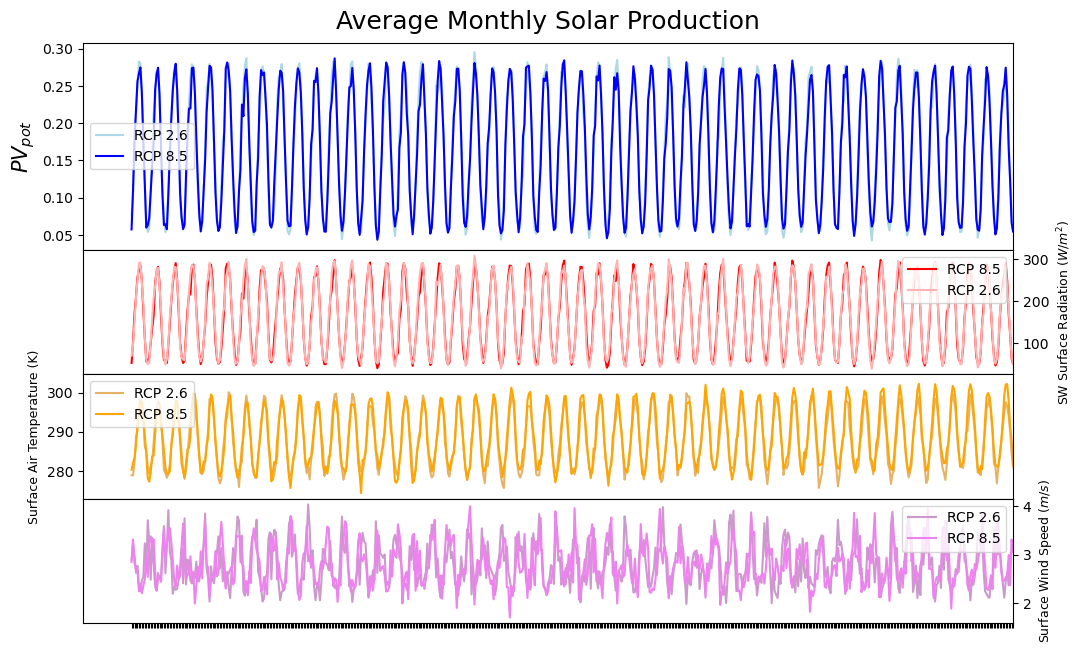

In [67]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

year = '2070-07'
year_ref = '2021-07'

months = ds_rcp26_monavg.strftime.values
fig = plt.figure(figsize=(12, 20))
# Create a gridspec with 2 rows and 2 columns
gs = gridspec.GridSpec(8, 2, height_ratios=[2.5, 1.5, 1.5, 1.5, 0.8,4, 0.6, 4], figure = fig, hspace=0, wspace=0.2)

# Creating Subplots
ax1 = plt.subplot(gs[0, :],)
ax1_rsd = plt.subplot(gs[1, :], sharex = ax1,)
ax1_tas = plt.subplot(gs[2, :], sharex = ax1)
ax1_wind = plt.subplot(gs[3, :], sharex = ax1)


#ax2 = plt.subplot(gs[5, 0:1], projection=rotated_pole)
#ax3 = plt.subplot(gs[5, 1:], projection=rotated_pole)
#
#ax4 = plt.subplot(gs[7, 0:1], projection=rotated_pole)
#ax5 = plt.subplot(gs[7, 1:], projection=rotated_pole)
#
# Plot the data
ax1.plot(ds_rcp26_monavg_allita.pv_pot,'-', c='lightblue', label = 'RCP 2.6' , scalex = False)
ax1.plot(ds_rcp85_monavg_allita.pv_pot,'-', c='blue', label = 'RCP 8.5', scalex = False)
ax1_rsd.plot(months, ds_rcp85_monavg_allita.rsds,'-', c='r', label = 'RCP 8.5')
ax1_rsd.plot(months, ds_rcp26_monavg_allita.rsds,'-', c=(1, 0.7, 0.7), label = 'RCP 2.6')
ax1_tas.plot(months, ds_rcp26_monavg_allita.tas,'-', c=(0.9, 0.7, 0.4),label = 'RCP 2.6')
ax1_tas.plot(months, ds_rcp85_monavg_allita.tas,'-', c='orange',label='RCP 8.5')
ax1_wind.plot(months, ds_rcp26_monavg_allita.sfcWind,'-', c=(0.8,0.6,0.8),label = 'RCP 2.6')
ax1_wind.plot(months, ds_rcp85_monavg_allita.sfcWind,'-', c='violet',label = 'RCP 8.5')



#ds_rcp26_monavg.pv_pot.sel(strftime=year).plot.pcolormesh(ax=ax2, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
#(ds_rcp26_monavg.pv_pot.sel(strftime=year)-ds_rcp26_monavg.pv_pot.sel(strftime=year_ref)).plot.pcolormesh(ax=ax3, x="rlon", y='rlat', add_colorbar=True, cmap='Wistia')
#
#ds_rcp85_monavg.pv_pot.sel(strftime=year).plot.pcolormesh(ax=ax4, x="rlon", y='rlat', add_colorbar=True, cmap='jet', )
#(ds_rcp85_monavg.pv_pot.sel(strftime=year)-ds_rcp85_monavg.pv_pot.sel(strftime=year_ref)).plot.pcolormesh(ax=ax5, x="rlon", y='rlat', add_colorbar=True, cmap='Wistia')

#Formatting
ax1.set_title('Average Monthly Solar Production', fontdict={'fontsize': 18}, pad = 10)
ax1.set_xlabel('Month', fontsize = 15)
ax1.set_ylabel('$PV_{pot}$', fontsize = 15 )
ax1.legend()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, grid_alpha = 0.4, labelrotation = 60)
#ax1.grid(visible=True, ls = '--')
ax1.set_xlim(right = '2070-12')


ax1_rsd.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#ax1_rsd.grid(visible=True, ls = '--')
ax1_rsd.set_ylabel('SW Surface Radiation $(W/m^2)$', fontsize = 9)
ax1_rsd.yaxis.set_label_position('right')
ax1_rsd.tick_params(axis='y', which='both', labelleft=False, left=False, labelright=True, right = True)
ax1_rsd.legend(loc = 'upper right')
ax1_rsd.set_xlim(right = '2070-12')



ax1_tas.set_ylabel('Surface Air Temperature (K)', fontsize = 9)
ax1_tas.tick_params(axis='x', which='both', labelbottom=False, top=False)
#ax1_tas.grid(visible=True, ls = '--')
ax1_tas.legend()
ax1_tas.set_xlim(right = '2070-12')


ax1_wind.set_ylabel('Surface Wind Speed $(m/s)$', fontsize = 9)
ax1_wind.yaxis.set_label_position('right')
#ax1_wind.grid(visible=True, ls = '--')
ax1_wind.tick_params(axis='y', which='both', labelleft=False, left=False, labelright=True, right = True)
ax1_wind.legend(loc = 'upper right')
ax1_wind.set_xlim(right = '2070-12')


#ax2.set_title('$PV_{pot}$ Year='+str(year))
#ax3.set_title('$\Delta PV_{pot}$ '+str(year_ref)+' vs. 2021')
#ax4.set_title('$PV_{pot}$ Year='+str(year))
#ax5.set_title('$\Delta PV_{pot}$ '+str(year_ref)+' vs. 2021')
#
#ax2.coastlines()
#ax3.coastlines()
#ax4.coastlines()
#ax5.coastlines()

# Rotate x-axis labels on the first plot
ax1.tick_params(axis='x', rotation=60)

fig.autofmt_xdate()
plt.show()
